# CoEV Rank - Unexplained and explained coevolution search.

This notebook, compares a pdb structure (or two) to find unexplained and explained coevolution. It is derived from ColabDesign, as well as custom comparison and pymol related scripts.

This can be used most significantly for visualising and assessing the number of monomers that make up a homo-multimer, or if a protein is predicted by coevolution to form multimers and where. Therefore facilitating mutagenesis experiments.

It has the following inputs:

1. Sequence.
2. Pdb structures (multimer or not)

And the following outputs:

1. Coevolution and contact matrix of each setup compared

2. A PSE file of the multimer pdb, with coevolution contacts only explained by it, not the monomer.

In [ ]:
%%time
#@title setup
unified_memory = True #@param {type:"boolean"}
import os, time, gc
if unified_memory:
  ENV = {"TF_FORCE_UNIFIED_MEMORY":"1", "XLA_PYTHON_CLIENT_MEM_FRACTION":"4.0"}
  for k,v in ENV.items(): os.environ[k] = v
if not os.path.isdir("params"):
  # get code
  print("installing ColabDesign")
  os.system("(mkdir params; apt-get install aria2 -qq; \
  aria2c -q -x 16 https://storage.googleapis.com/alphafold/alphafold_params_2022-12-06.tar; \
  tar -xf alphafold_params_2022-12-06.tar -C params; touch params/done.txt )&")

  os.system("pip -q install git+https://github.com/sokrypton/ColabDesign.git@gamma")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabdesign colabdesign")
  os.system("wget https://raw.githubusercontent.com/sokrypton/ColabFold/main/colabfold/colabfold.py -O colabfold_utils.py")
  #os.system("wget https://raw.githubusercontent.com/sokrypton/ColabFold/beta/colabfold/mmseqs/api.py")

  # install hhsuite
  print("installing HHsuite")
  os.makedirs("hhsuite", exist_ok=True)
  os.system(f"curl -fsSL https://github.com/soedinglab/hh-suite/releases/download/v3.3.0/hhsuite-3.3.0-SSE2-Linux.tar.gz | tar xz -C hhsuite/")

  # download params
  if not os.path.isfile("params/done.txt"):
    print("downloading AlphaFold params")
    while not os.path.isfile("params/done.txt"):
      time.sleep(5)
if "hhsuite" not in os.environ['PATH']:
  os.environ['PATH'] += ":hhsuite/bin:hhsuite/scripts"

import re, tempfile
from IPython.display import HTML
from google.colab import files
import numpy as np
from colabdesign import mk_af_model, clear_mem
from colabdesign.af.contrib import predict
from colabdesign.af.contrib.cyclic import add_cyclic_offset
from colabdesign.shared.protein import _np_rmsd, _np_kabsch
from colabdesign.shared.plot import plot_pseudo_3D, pymol_cmap


import jax
import jax.numpy as jnp
from colabfold_utils import run_mmseqs2
import matplotlib.pyplot as plt
import string
import numpy as np

def clear_mem():
  backend = jax.lib.xla_bridge.get_backend()
  for buf in backend.live_buffers(): buf.delete()

def get_pdb(pdb_code=""):
  if pdb_code is None or pdb_code == "":
    upload_dict = files.upload()
    pdb_string = upload_dict[list(upload_dict.keys())[0]]
    with open("tmp.pdb","wb") as out: out.write(pdb_string)
    return "tmp.pdb"
  elif os.path.isfile(pdb_code):
    return pdb_code
  elif len(pdb_code) == 4:
    os.makedirs("tmp",exist_ok=True)
    os.system(f"wget -qnc https://files.rcsb.org/download/{pdb_code}.cif -P tmp/")
    return f"tmp/{pdb_code}.cif"
  else:
    os.makedirs("tmp",exist_ok=True)
    os.system(f"wget -qnc https://alphafold.ebi.ac.uk/files/AF-{pdb_code}-F1-model_v4.pdb -P tmp/")
    return f"tmp/AF-{pdb_code}-F1-model_v4.pdb"

def run_hhalign(query_sequence, target_sequence, query_a3m=None, target_a3m=None):
  with tempfile.NamedTemporaryFile() as tmp_query, \
  tempfile.NamedTemporaryFile() as tmp_target, \
  tempfile.NamedTemporaryFile() as tmp_alignment:
    if query_a3m is None:
      tmp_query.write(f">Q\n{query_sequence}\n".encode())
      tmp_query.flush()
      query_a3m = tmp_query.name
    if target_a3m is None:
      tmp_target.write(f">T\n{target_sequence}\n".encode())
      tmp_target.flush()
      target_a3m = tmp_target.name
    os.system(f"hhalign -hide_cons -i {query_a3m} -t {target_a3m} -o {tmp_alignment.name}")
    X, start_indices = predict.parse_hhalign_output(tmp_alignment.name)
  return X, start_indices

def run_do_not_align(query_sequence, target_sequence, **arg):
  return [query_sequence,target_sequence],[0,0]

def run_hhfilter(input, output, id=90, qid=10):
  os.system(f"hhfilter -id {id} -qid {qid} -i {input} -o {output}")

def plot_3D(aux, Ls, file_name, show=False):
  plt.figure(figsize=(10,5))
  xyz = aux["atom_positions"][:,1]
  xyz = xyz @ _np_kabsch(xyz, xyz, return_v=True, use_jax=False)
  ax = plt.subplot(1,2,1)
  if len(Ls) > 1:
    plt.title("chain")
    c = np.concatenate([[n]*L for n,L in enumerate(Ls)])
    plot_pseudo_3D(xyz=xyz, c=c, cmap=pymol_cmap, cmin=0, cmax=39, Ls=Ls, ax=ax)
  else:
    plt.title("length")
    plot_pseudo_3D(xyz=xyz, Ls=Ls, ax=ax)
  plt.axis(False)
  ax = plt.subplot(1,2,2)
  plt.title("plddt")
  plot_pseudo_3D(xyz=xyz, c=aux["plddt"], cmin=0.5, cmax=0.9, Ls=Ls, ax=ax)
  plt.axis(False)
  plt.savefig(file_name, dpi=200, bbox_inches='tight')
  plt.show() if show else plt.close()

installing ColabDesign
installing HHsuite
downloading AlphaFold params
CPU times: user 1.7 s, sys: 325 ms, total: 2.03 s
Wall time: 2min


jobname Ylxx_fa497
length=[235] copies=1
getting unpaired MSA


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:28 remaining: 00:00]


parsing msas
gathering info
filtering sequences
selecting final sequences


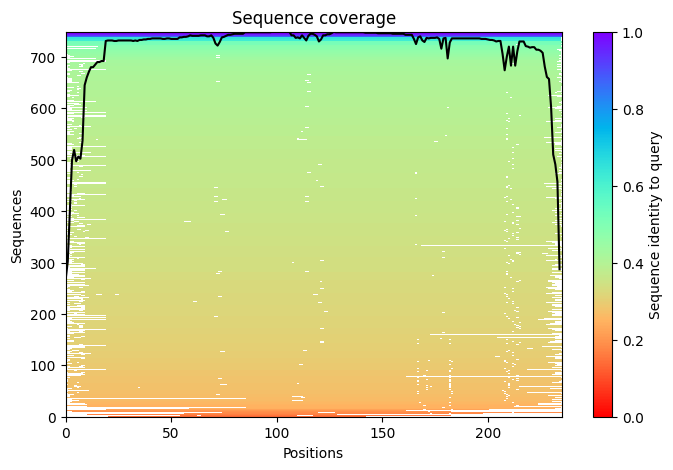

GC 5246


In [ ]:
#@title Input Sequence and Jobname
sequence = "MKIKRSFISI SVLMVIFGLM ISVQFNSLKH PKVRDTRDMW DIREELTSEQ KKQEKLLAEI NKYDKLLNSY SQTKEMTKET ALNNTLQSLK KTAGMTDITG SGIVITISPL  FSESLTGEPI ENPPPDLLKK LINELNSYGA EHISINERRV VNHTVIRDIN GTTKIDGYAL DDYPLTVKVL AKDPDMLHSR VKGSGLEDLF ASENLALKAG KSESKLTLKA  YDRPLDVQQL KLLKD" #@param {type:"string"}
jobname = "Ylxx" #@param {type:"string"}
query_sequence = sequence
copies = 1
#@markdown ----
#@markdown **MSA options**
msa_method = "mmseqs2" #@param ["mmseqs2","single_sequence", "custom_fas", "custom_a3m", "custom_sto"]
pair_mode = "paired" #@param ["unpaired_paired","paired","unpaired"] {type:"string"}
#@markdown filtering options
cov = 50 #@param ["0", "25", "50", "75", "90", "99"] {type:"raw"}
id = 100 #@param ["90", "95" "100"] {type:"raw"}
qid = 0 #@param ["0", "10", "15", "20", "30"] {type:"raw"}
do_not_filter = False #@param {type:"boolean"}


template_mode = "none"
use_templates = template_mode in ["mmseqs2","custom"]
pdb = ""
chain = "A"
rm_template_seq = False
propagate_to_copies = True
do_not_align = False
rm_sidechain = rm_sequence = rm_template_seq

# filter options
sequence = sequence.upper()
sequence = re.sub("[^A-Z:/()]", "", sequence.upper())
sequence = re.sub("\(",":(", sequence)
sequence = re.sub("\)","):", sequence)
sequence = re.sub(":+",":",sequence)
sequence = re.sub("/+","/",sequence)
sequence = re.sub("^[:/]+","",sequence)
sequence = re.sub("[:/]+$","",sequence)
jobname = re.sub(r'\W+', '', jobname)

# process sequence
sequences = sequence.split(":")
u_sequences = predict.get_unique_sequences(sequences)
u_cyclic = [x.startswith("(") for x in u_sequences]
u_sub_lengths = [[len(y) for y in x.split("/")] for x in u_sequences]
u_sequences = [x.replace("(","").replace(")","").replace("/","") for x in u_sequences]
if len(sequences) > len(u_sequences):
  print("WARNING: use copies to define homooligomers")
u_lengths = [len(x) for x in u_sequences]
sub_seq = "".join(u_sequences)
seq = sub_seq * copies

jobname = f"{jobname}_{predict.get_hash(seq)[:5]}"
def check(folder): return os.path.exists(folder)
if check(jobname):
  n = 0
  while check(f"{jobname}_{n}"): n += 1
  jobname = f"{jobname}_{n}"

print("jobname",jobname)
print(f"length={u_lengths} copies={copies}")

input_opts = {"sequence":u_sequences,
              "copies":copies,
              "msa_method":msa_method,
              "pair_mode":pair_mode,
              "do_not_filter":do_not_filter,
              "cov":cov,
              "id":id,
              "template_mode":template_mode,
              "propagate_to_copies":propagate_to_copies}

def run_mmseqs2_wrapper(*args, **kwargs):
  kwargs['user_agent'] = "colabdesign/gamma"
  return run_mmseqs2(*args, **kwargs)

##################
# GET MSA
##################
os.makedirs(jobname, exist_ok=True)

Ls = [len(x) for x in u_sequences]
if msa_method == "mmseqs2":
  msa, deletion_matrix = predict.get_msa(u_sequences, jobname,
    mode=pair_mode,
    cov=cov, id=id, qid=qid, max_msa=4096,
    do_not_filter=do_not_filter,
    mmseqs2_fn=run_mmseqs2_wrapper,
    hhfilter_fn=run_hhfilter)

elif msa_method == "single_sequence":
  with open(f"{jobname}/msa.a3m","w") as a3m:
    a3m.write(f">{jobname}\n{sub_seq}\n")
  msa, deletion_matrix = predict.parse_a3m(f"{jobname}/msa.a3m")

else:
  msa_format = msa_method.split("_")[1]
  print(f"upload {msa_method}")
  msa_dict = files.upload()
  lines = []
  for k,v in msa_dict.items():
    lines += v.decode().splitlines()
  input_lines = []
  for line in lines:
    line = line.replace("\x00","")
    if len(line) > 0 and not line.startswith('#'):
      input_lines.append(line)
  with open(f"{jobname}/msa.{msa_format}","w") as msa:
    msa.write("\n".join(input_lines))
  if msa_format != "a3m":
    os.system(f"perl hhsuite/scripts/reformat.pl {msa_format} a3m {jobname}/msa.{msa_format} {jobname}/msa.a3m")
  if do_not_filter:
    os.system(f"hhfilter -qid 0 -id 100 -cov 0 -i {jobname}/msa.a3m -o {jobname}/msa.filt.a3m")
  else:
    os.system(f"hhfilter -qid {qid} -id {id} -cov {cov} -i {jobname}/msa.a3m -o {jobname}/msa.filt.a3m")
  msa, deletion_matrix = predict.parse_a3m(f"{jobname}/msa.filt.a3m")

if len(msa) > 1:
  predict.plot_msa(msa, Ls)
  plt.savefig(f"{jobname}/msa_feats.png", dpi=200, bbox_inches='tight')
  plt.show()

##################
if use_templates:
  print("aligning template")
  template_msa = f"{jobname}/msa.a3m"
  if template_mode == "mmseqs2":
    predict.get_msa(u_sequences, jobname,
      mode="unpaired",
      mmseqs2_fn=run_mmseqs2_wrapper,
      do_not_filter=True,
      do_not_return=True,
      output_a3m=f"{jobname}/msa_tmp.a3m")
    template_msa = f"{jobname}/msa_tmp.a3m"
    if not propagate_to_copies and copies > 1:
      new_msa = []
      with open(template_msa, "r") as handle:
        for line in handle:
          if not line.startswith(">"):
            new_msa.append(line.rstrip())
      with open(template_msa, "w") as handle:
        for n,seq in enumerate(new_msa):
          handle.write(f">{n}\n{seq*copies}\n")

    templates = {}
    print("ID\tpdb\tcid\tevalue")
    for line in open(f"{jobname}/msa/_env/pdb70.m8","r"):
      p = line.rstrip().split()
      M,target_id,qid,e_value = p[0],p[1],p[2],p[10]
      M = int(M)
      if M not in templates:
        templates[M] = []
      if len(templates[M]) < 4:
        print(f"{int(M)}\t{target_id}\t{qid}\t{e_value}")
        templates[M].append(target_id)
    if len(templates) == 0:
      use_templates = False
      print("ERROR: no templates found...")
    else:
      Ms = sorted(list(templates.keys()))
      pdbs,chains = [],[]
      for M in Ms:
        for n,target_id in enumerate(templates[M]):
          pdb_id,chain_id = target_id.split("_")
          if len(pdbs) < n+1:
            pdbs.append([])
            chains.append([])
          pdbs[n].append(pdb_id)
          chains[n].append(chain_id)
      print(pdbs)
  else:
    pdbs,chains = [pdb],[chain]

if use_templates:
  input_opts.update({"pdbs":pdbs, "chains":chains})
  batches = []
  for pdb,chain in zip(pdbs,chains):
    query_seq = "".join(u_sequences)
    batch = predict.get_template_feats(pdb, chain,
      query_seq=query_seq,
      query_a3m=template_msa,
      copies=copies,
      propagate_to_copies=propagate_to_copies,
      use_seq=not rm_sequence,
      get_pdb_fn=get_pdb,
      align_fn=run_do_not_align if do_not_align else run_hhalign)
    batches.append(batch)

  # for display
  plt.figure(figsize=(3*len(batches),3))
  for n,batch in enumerate(batches):
    plt.subplot(1,len(batches),n+1)
    plt.title(f"template features {n+1}")
    dgram = batch["dgram"].argmax(-1).astype(float)
    dgram[batch["dgram"].sum(-1) == 0] = np.nan
    Ln = dgram.shape[0]
    plt.imshow(dgram, extent=(0, Ln, Ln, 0))
    predict.plot_ticks(Ls * copies)
  plt.savefig(f"{jobname}/template_feats.png", dpi=200, bbox_inches='tight')
  plt.show()
else:
  batches = [None]

################
print("GC",gc.collect())

In [ ]:
#@title Import softwares
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
import matplotlib.pylab as plt
from scipy import stats
from scipy.spatial.distance import pdist, squareform
from scipy.special import logsumexp
import pandas as pd

In [ ]:
################
# note: if you are modifying the alphabet
# make sure last character is "-" (gap)
################
alphabet = "ARNDCQEGHILKMFPSTWYV-"
states = len(alphabet)

# map amino acids to integers (A->0, R->1, etc)
a2n = dict((a,n) for n,a in enumerate(alphabet))
aa2int = lambda x: a2n.get(x,a2n['-'])

In [ ]:
#@title Convert the MSA results into a co-evolution input
print("jobname",jobname)
filename  = f'{jobname}/msa.a3m'
def parse_a3m(filename):
    names, seqs = [], []
    current_seq = ""

    with open(filename, "r") as file:
        for line in file:
            line = line.rstrip()

            if line.startswith(">"):
                if current_seq:
                    # Remove lowercase letters from the sequence
                    current_seq = ''.join([char if char.isupper() or char == '-' else '' for char in current_seq])
                    if current_seq.strip():  # Check if the current sequence is not empty
                        seqs.append(current_seq)
                    current_seq = ""
                names.append(line[1:])
            else:
                current_seq += line

    if current_seq:
        # Remove lowercase letters from the sequence
        current_seq = ''.join([char if char.isupper() or char == '-' else '' for char in current_seq])
        if current_seq.strip():  # Check if the last sequence is not empty
            seqs.append(current_seq)

    return names, seqs
names, seqs = parse_a3m(filename)


def filt_gaps(msa, gap_cutoff=0.5):
  '''filters alignment to remove gappy positions'''
  frac_gaps = np.mean((msa == states-1).astype(float),0)
  non_gaps = np.where(frac_gaps < gap_cutoff)[0]
  return msa[:,non_gaps], non_gaps

def get_eff(msa, eff_cutoff=0.8):
  '''compute effective weight for each sequence'''
  msa_sm = 1.0 - squareform(pdist(msa,"hamming"))
  msa_w = (msa_sm >= eff_cutoff).astype(float)
  msa_w = 1.0/np.sum(msa_w,-1)
  return msa_w

def str2int(x):
  '''convert a list of strings into list of integers'''
  # Example: ["ACD","EFG"] -> [[0,4,3], [6,13,7]]
  if x.dtype.type is np.str_:
    if x.ndim == 0: return np.array([aa2int(aa) for aa in x])
    else: return np.array([[aa2int(aa) for aa in seq] for seq in x])
  else:
    return x

def split_train_test(seqs, frac_test=0.1):
  # shuffle data
  x = np.copy(seqs)
  np.random.shuffle(x[1:])

  # fraction of data used for testing
  split = int(len(x) * (1.0-frac_test))

  # split training/test datasets
  return x[:split], x[split:]

def mk_msa(seqs, gap_cutoff=0.5, eff_cutoff=0.8):
  '''converts list of sequences to MSA (Multiple Sequence Alignment)'''
  # =============================================================================
  # The function takes a list of sequences (strings) and returns a (dict)ionary
  # containing the following:
  # =============================================================================
  # BEFORE GAP REMOVAL
  # -----------------------------------------------------------------------------
  # msa_ori   msa
  # ncol_ori  number of columns
  # -----------------------------------------------------------------------------
  # AFTER GAP REMOVAL
  # By default, columns with ≥ 50% gaps are removed. This makes things a
  # little complicated, as we need to keep track of which positions were removed.
  # -----------------------------------------------------------------------------
  # msa       msa
  # ncol      number of columns
  # v_idx     index of positions kept
  # -----------------------------------------------------------------------------
  # weights   weight for each sequence (based on sequence identity)
  # nrow      number of rows (sequences)
  # neff      number of effective sequences sum(weights)
  # =============================================================================

  msa_ori = str2int(seqs)

  # remove positions with more than > 50% gaps
  msa, v_idx = filt_gaps(msa_ori)

  # compute effective weight for each sequence
  msa_weights = get_eff(msa, eff_cutoff)

  return {"msa_ori":msa_ori,
          "msa":msa,
          "weights":msa_weights,
          "neff":np.sum(msa_weights),
          "v_idx":v_idx,
          "nrow":msa.shape[0],
          "ncol":msa.shape[1],
          "ncol_ori":msa_ori.shape[1]}

jobname Ylxx_fa497


In [ ]:
#@title GREMLIN preload - optimizer
def opt_adam(loss, name, var_list=None, lr=1.0, b1=0.9, b2=0.999, b_fix=False):
  # adam optimizer
  # Note: this is a modified version of adam optimizer. More specifically, we replace "vt"
  # with sum(g*g) instead of (g*g). Furthmore, we find that disabling the bias correction
  # (b_fix=False) speeds up convergence for our case.

  if var_list is None: var_list = tf.trainable_variables()
  gradients = tf.gradients(loss,var_list)
  if b_fix: t = tf.Variable(0.0,"t")
  opt = []
  for n,(x,g) in enumerate(zip(var_list,gradients)):
    if g is not None:
      ini = dict(initializer=tf.zeros_initializer,trainable=False)
      mt = tf.get_variable(name+"_mt_"+str(n),shape=list(x.shape), **ini)
      vt = tf.get_variable(name+"_vt_"+str(n),shape=[], **ini)

      mt_tmp = b1*mt+(1-b1)*g
      vt_tmp = b2*vt+(1-b2)*tf.reduce_sum(tf.square(g))
      lr_tmp = lr/(tf.sqrt(vt_tmp) + 1e-8)

      if b_fix: lr_tmp = lr_tmp * tf.sqrt(1-tf.pow(b2,t))/(1-tf.pow(b1,t))

      opt.append(x.assign_add(-lr_tmp * mt_tmp))
      opt.append(vt.assign(vt_tmp))
      opt.append(mt.assign(mt_tmp))

  if b_fix: opt.append(t.assign_add(1.0))
  return(tf.group(opt))

In [ ]:
#@title GREMLIN - optimiser is default
def GREMLIN(msa,
            opt_iter=100,
            opt_rate=1.0,
            batch_size=None,
            lam_v=0.01,
            lam_w=0.01,
            scale_lam_w=True,
            v=None,
            w=None,
            ignore_gap=True):

  '''fit params of MRF (Markov Random Field) given MSA (multiple sequence alignment)'''
  # ==========================================================================
  # this function takes a MSA (dict)ionary, from mk_msa() and returns a MRF
  # (dict)ionary containing the following:
  # ==========================================================================
  # len       full length
  # v_idx     index of positions (mapping back to full length)
  # v         2-body term
  # w         2-body term
  # ==========================================================================
  # WARNING: The mrf is over the msa after gap removal. "v_idx" and "len" are
  # important for mapping the MRF back to the original MSA.
  # ==========================================================================

  ########################################
  # SETUP COMPUTE GRAPH
  ########################################
  # reset tensorflow graph
  tf.reset_default_graph()

  # length of sequence
  ncol = msa["ncol"]

  # input msa (multiple sequence alignment)
  MSA = tf.placeholder(tf.int32,shape=(None,ncol),name="msa")

  # input msa weights
  MSA_weights = tf.placeholder(tf.float32, shape=(None,), name="msa_weights")

  # one-hot encode msa
  OH_MSA = tf.one_hot(MSA,states)

  if ignore_gap:
    ncat = states - 1
    NO_GAP = 1.0 - OH_MSA[...,-1]
    OH_MSA = OH_MSA[...,:ncat]

  else:
    ncat = states

  ########################################
  # V: 1-body-term of the MRF
  ########################################
  V = tf.get_variable(name="V",
                          shape=[ncol,ncat],
                          initializer=tf.zeros_initializer)

  ########################################
  # W: 2-body-term of the MRF
  ########################################
  W_tmp = tf.get_variable(name="W",
                          shape=[ncol,ncat,ncol,ncat],
                          initializer=tf.zeros_initializer)

  # symmetrize W
  W = W_tmp + tf.transpose(W_tmp,[2,3,0,1])

  # set diagonal to zero
  W = W * (1-np.eye(ncol))[:,None,:,None]

  ########################################
  # Pseudo-Log-Likelihood
  ########################################
  # V + W
  VW = V + tf.tensordot(OH_MSA,W,2)

  # hamiltonian
  H = tf.reduce_sum(OH_MSA*VW,-1)

  # local Z (parition function)
  Z = tf.reduce_logsumexp(VW,-1)

  PLL = H - Z
  if ignore_gap:
    PLL = PLL * NO_GAP

  PLL = tf.reduce_sum(PLL,-1)
  PLL = tf.reduce_sum(MSA_weights * PLL)/tf.reduce_sum(MSA_weights)

  ########################################
  # Regularization
  ########################################
  L2 = lambda x: tf.reduce_sum(tf.square(x))
  L2_V = lam_v * L2(V)
  L2_W = lam_w * L2(W) * 0.5

  if scale_lam_w:
    L2_W = L2_W * (ncol-1) * (states-1)

  ########################################
  # Loss Function
  ########################################
  # loss function to minimize
  loss = -PLL + (L2_V + L2_W) / msa["neff"]

  # optimizer
  opt = opt_adam(loss,"adam",lr=opt_rate)

  ########################################
  # Input Generator
  ########################################
  all_idx = np.arange(msa["nrow"])
  def feed(feed_all=False):
    if batch_size is None or feed_all:
      return {MSA:msa["msa"], MSA_weights:msa["weights"]}
    else:
      batch_idx = np.random.choice(all_idx,size=batch_size)
      return {MSA:msa["msa"][batch_idx], MSA_weights:msa["weights"][batch_idx]}

  ########################################
  # OPTIMIZE
  ########################################
  with tf.Session() as sess:

    # initialize variables V and W
    sess.run(tf.global_variables_initializer())

    # initialize V
    if v is None:
      oh_msa = np.eye(states)[msa["msa"]]
      if ignore_gap: oh_msa = oh_msa[...,:-1]

      pseudo_count = 0.01 * np.log(msa["neff"])
      f_v = np.einsum("nla,n->la",oh_msa,msa["weights"])
      V_ini = np.log(f_v + pseudo_count)
      if lam_v > 0:
        V_ini = V_ini - np.mean(V_ini,axis=-1,keepdims=True)
      sess.run(V.assign(V_ini))

    else:
      sess.run(V.assign(v))

    # initialize W
    if w is not None:
      sess.run(W_tmp.assign(w * 0.5))

    # compute loss across all data
    get_loss = lambda: np.round(sess.run(loss,feed(True)) * msa["neff"],2)

    print("starting",get_loss())
    for i in range(opt_iter):
      sess.run(opt,feed())
      if (i+1) % int(opt_iter/10) == 0:
        print("iter",(i+1),get_loss())

    # save the V and W parameters of the MRF
    V_ = sess.run(V)
    W_ = sess.run(W)

  ########################################
  # return MRF
  ########################################
  no_gap_states = states - 1
  mrf = {"v": V_[:,:no_gap_states],
         "w": W_[:,:no_gap_states,:,:no_gap_states],
         "v_idx": msa["v_idx"],
         "len": msa["ncol_ori"]}

  return mrf

In [ ]:
headers, seqs = parse_a3m(filename)

train_seqs, test_seqs = split_train_test(seqs, frac_test=0.1)

msa = mk_msa(train_seqs, gap_cutoff=0.5, eff_cutoff=0.8)


In [ ]:
%%time
# ==========================================================================
# RUN GREMLIN
# ==========================================================================
mrf = GREMLIN(msa,lam_w=0.01)

# NOTE: lam_v (for one-body term) lam_w (for two-body term) can be used to regularize the model
#
# for contact prediction we find lam_w = 0.01 to be most optimial
# (even though it's technically overfitting on the data!)
# the overfitting is partly corrected by APC
#
# for design/scoring you may want to bump the lam_w to a higher value!


starting 142420.87
iter 10 83215.96
iter 20 80125.11
iter 30 76866.51
iter 40 76172.91
iter 50 75852.37
iter 60 75733.76
iter 70 75679.26
iter 80 75652.92
iter 90 75638.44
iter 100 75629.23
CPU times: user 3.1 s, sys: 984 ms, total: 4.08 s
Wall time: 9.15 s


In [ ]:
#@title Score calculation
def score(mrf, x, recompute_z=False):
  x = str2int(x)

  # if length of sequence != length of model
  if x.shape[-1] != len(mrf["v_idx"]):
    x = x[...,mrf["v_idx"]]

  # one hot encode
  x = np.eye(states)[x]

  # get non-gap positions
  no_gap = 1.0 - x[...,-1]

  # remove gap from one-hot-encoding
  x = x[...,:-1]

  # compute score
  vw = mrf["v"] + np.tensordot(x,mrf["w"],2)

  # ============================================================================================
  # Note, Z (the partition function) is a constant. In GREMLIN, V, W & Z are estimated using all
  # the original weighted input sequence(s). It is NOT recommended to recalculate Z with a
  # different set of sequences. Given the common ERROR of recomputing Z, we include the option
  # to do so, for comparison.
  # ============================================================================================
  h = np.sum(np.multiply(x,vw),axis=-1)
  if recompute_z:
    z = logsumexp(vw, axis=-1)
    return np.sum((h-z), axis=-1)
  else:
    return np.sum(h, axis=-1)

In [ ]:
#@title GREMLIN contact map
def normalize(x):
  x = stats.boxcox(x - np.amin(x) + 1.0)[0]
  x_mean = np.mean(x)
  x_std = np.std(x)
  return((x-x_mean)/x_std)

def get_mtx(mrf):
  '''convert MRF (Markov Random Field) to MTX (Matrix or Contact-map)'''

  # raw (l2norm of each 20x20 matrix)
  raw_sq = np.sqrt(np.sum(np.square(mrf["w"]),(1,3)))
  raw = squareform(raw_sq, checks=False)

  # apc (average product correction)
  ap_sq = np.sum(raw_sq,0,keepdims=True) * np.sum(raw_sq,1,keepdims=True)/np.sum(raw_sq)
  apc = squareform(raw_sq - ap_sq, checks=False)

  i, j = np.triu_indices_from(raw_sq,k=1)
  mtx = {
         "i": mrf["v_idx"][i],
         "j": mrf["v_idx"][j],
         "raw": raw,
         "apc": apc,
         "zscore": normalize(apc),
         "len": mrf["len"]
  }
  return mtx

def plot_mtx(mtx):
  '''plot the mtx'''
  plt.figure(figsize=(8,8))
  for n, key in enumerate(["zscore"]):

    # create empty mtx
    m = np.ones((mtx["len"],mtx["len"])) * np.nan

    # populate
    m[mtx["i"],mtx["j"]] = mtx[key]
    m[mtx["j"],mtx["i"]] = m[mtx["i"],mtx["j"]]

    #plot
    plt.plot
    plt.title("Co-Evolution Matrix (GREMLIN_ZScore)")
    if key == "zscore": plt.imshow(m, cmap='Blues', vmin=0.5, vmax=3)
    else: plt.imshow(m, cmap='binary')
    plt.grid(False)
    seq1 =len(query_sequence.split(':')[0])
    if ':' in query_sequence:
      plt.axvline(x = seq1)
      plt.axhline(y = seq1)
    plt.xlabel("Protein Amino acids")
  plt.savefig(f'co-ev{jobname}.png')
  plt.show()


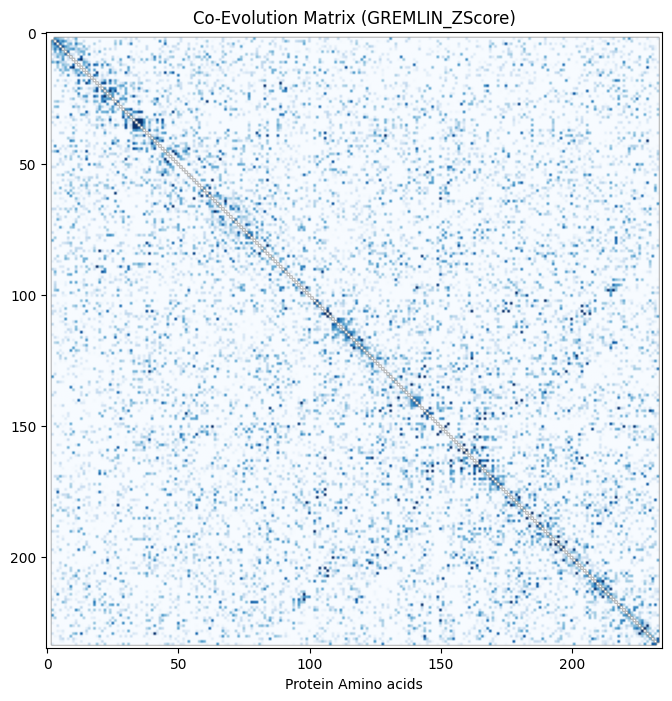

In [ ]:
query_sequence = sequence
mtx = get_mtx(mrf)
plot_mtx(mtx)

In [ ]:
pd_mtx = pd.DataFrame(mtx,columns=["i","j","raw","apc","zscore","i_aa","j_aa"])
coev_mtx = pd.DataFrame(mtx,columns=["i","j","zscore"])

In [ ]:
#@title Install PyMOL
!python -m pip install --upgrade pip
!pip install tr-rosetta-pytorch
!apt-get install pymol

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.7 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 MB 48.0 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=8034510aa43f9da047413cb01f025d53e966cc6b9df6bf82733c5a4dc41d23e0
  Stored in directory: /root/.cache/pip/wheels/46/54/24/1624fd5b8674eb1188623f7e8e17cdf7c0f6c24b609dfb8a89
Successfully built fire
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  apbs apbs-data freeglut3 libapbs3 libevdev2 libglu1-mesa libgudev-1.0-0 libinput-bin libinput10
  libmaloc1 libmd4c0 libmtdev1 libqt5core5a libqt5dbus5 libqt5designer5 libqt5gui5 libqt5help5
  libqt5network5 libqt5opengl5 libqt5pr

In [ ]:
from google.colab import files
import os

uploaded = files.upload()
filename = next(iter(uploaded.keys()))
#@title Upload the MONOMER pdb file with the correct chain length
jobname = os.path.splitext(filename)[0]
print(f"Job name: {jobname}")

Saving AF-Q45544-F1-model_v4.pdb to AF-Q45544-F1-model_v4.pdb
Job name: AF-Q45544-F1-model_v4


In [ ]:
from google.colab import files
import os
#@title (optional)Upload the MULTIMER pdb file with the correct chain length
#@markdown Tick box if youd like to see your multimers 'multimer only' explaiend coevolution
multimer =True # @param {type:"boolean"}
if multimer == True:
  uploaded1 = files.upload()
  filename1 = next(iter(uploaded1.keys()))


Saving foldylxx.pdb to foldylxx.pdb


In [ ]:
!pip install biopython matplotlib numpy


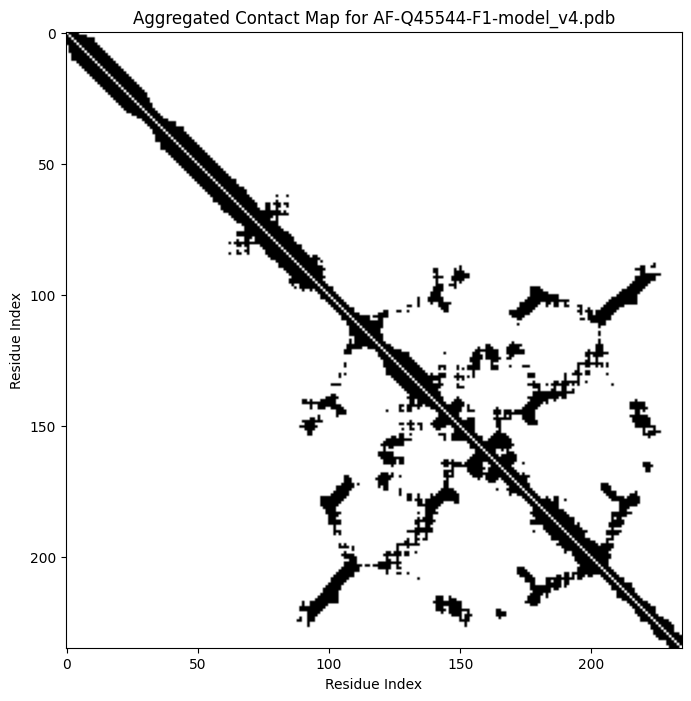

/usr/local/lib/python3.11/dist-packages/Bio/PDB/PDBParser.py:384: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3719
  warnings.warn(


<Figure size 640x480 with 0 Axes>

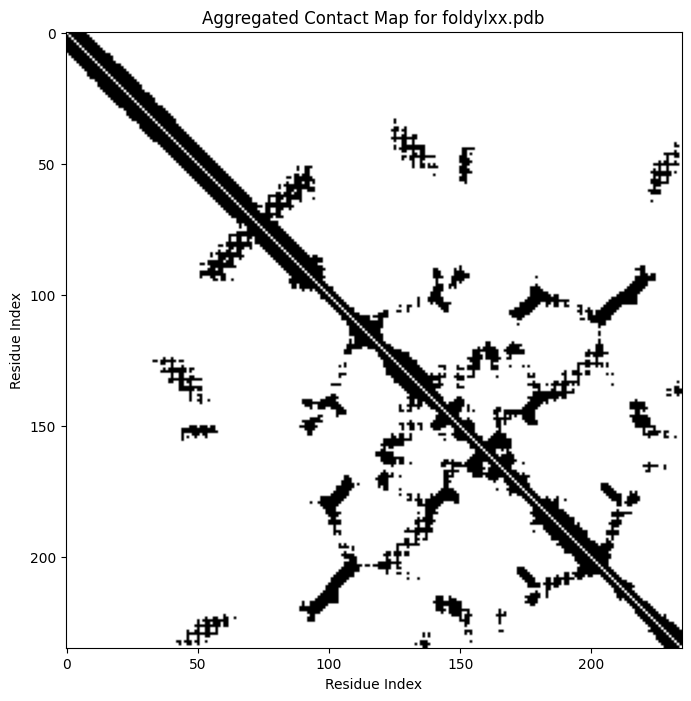

In [ ]:
from Bio.PDB import PDBParser
import numpy as np
import matplotlib.pyplot as plt

# Load and parse the first PDB file
pdb_filename = next(iter(uploaded))
parser = PDBParser()
structure = parser.get_structure('structure', pdb_filename)

# Extract chains from the structure and initialize the first chain
chains = list(structure.get_chains())
first_chain_residues = []
chain_length = 0

# Extract alpha-carbon (CA) atoms from the first chain
for residue in chains[0]:
    if 'CA' in residue:
        first_chain_residues.append(residue['CA'].get_coord())
        chain_length += 1

# Initialize the contact map matrix for the first chain
contact_map = np.zeros((chain_length, chain_length))

# Set cutoff distance in Angstroms
cutoff_distance = 12.0

# Calculate contact map for the first chain
for i in range(chain_length):
    for j in range(i + 1, chain_length):
        distance = np.linalg.norm(first_chain_residues[i] - first_chain_residues[j])
        if distance < cutoff_distance:
            contact_map[i, j] += 1
            contact_map[j, i] += 1

# Initialize aggregated contact map across all chains
num_chains = len(chains)
aggregated_contact_map = np.zeros_like(contact_map)

# Aggregate contact maps across all chains
for chain1 in chains:
    for chain2 in chains:
        for i in range(chain_length):
            residue1 = list(chain1)[i]
            for j in range(i + 1, chain_length):
                residue2 = list(chain2)[j]
                if 'CA' in residue1 and 'CA' in residue2:
                    coord1 = residue1['CA'].get_coord()
                    coord2 = residue2['CA'].get_coord()
                    distance = np.linalg.norm(coord1 - coord2)
                    if distance < cutoff_distance:
                        aggregated_contact_map[i, j] += 1
                        aggregated_contact_map[j, i] += 1

# Binarize the aggregated contact map
aggregated_contact_map = np.where(aggregated_contact_map != 0, 1, 0)

# Plot and save the aggregated contact map
plt.figure(figsize=(8, 8))
plt.imshow(aggregated_contact_map, cmap='Greys', origin='upper')
plt.title(f'Aggregated Contact Map for {pdb_filename}')
plt.xlabel('Residue Index')
plt.ylabel('Residue Index')
plt.show()
plt.savefig(f'Aggregated Contact Map for {pdb_filename}.jpg', dpi=300)

# Load and parse the second PDB file
if multimer == True :
  pdb_filename1 = next(iter(uploaded1))
  structure1 = parser.get_structure('structure', pdb_filename1)

# Check if the structure is a multimer
  chains1 = list(structure1.get_chains())
  first_chain_residues1 = []
  chain_length1 = 0
  for residue1 in chains1[0]:
        if 'CA' in residue1:
            first_chain_residues1.append(residue1['CA'].get_coord())
            chain_length1 += 1
        contact_map1 = np.zeros((chain_length1, chain_length1))

        for i in range(chain_length1):
          for j in range(i + 1, chain_length1):
              distance1 = np.linalg.norm(first_chain_residues1[i] - first_chain_residues1[j])
              if distance1 < cutoff_distance:
                  contact_map1[i, j] += 1
                  contact_map1[j, i] += 1

  num_chains1 = len(chains1)
  aggregated_contact_map1 = np.zeros_like(contact_map1)

  # Aggregate contact maps across all chains
  for chain3 in chains1:
      for chain4 in chains1:
          for i in range(chain_length1):
              residue1 = list(chain3)[i]
              for j in range(i + 1, chain_length1):
                    residue2 = list(chain4)[j]
                    if 'CA' in residue1 and 'CA' in residue2:
                        coord1 = residue1['CA'].get_coord()
                        coord2 = residue2['CA'].get_coord()
                        distance1 = np.linalg.norm(coord1 - coord2)
                        if distance1 < cutoff_distance:
                            aggregated_contact_map1[i, j] += 1
                            aggregated_contact_map1[j, i] += 1

  aggregated_contact_map1 = np.where(aggregated_contact_map1 != 0, 1, 0)
  plt.figure(figsize=(8, 8))
  plt.imshow(aggregated_contact_map1, cmap='Greys', origin='upper')
  plt.title(f'Aggregated Contact Map for {pdb_filename1}')
  plt.xlabel('Residue Index')
  plt.ylabel('Residue Index')
  plt.show()


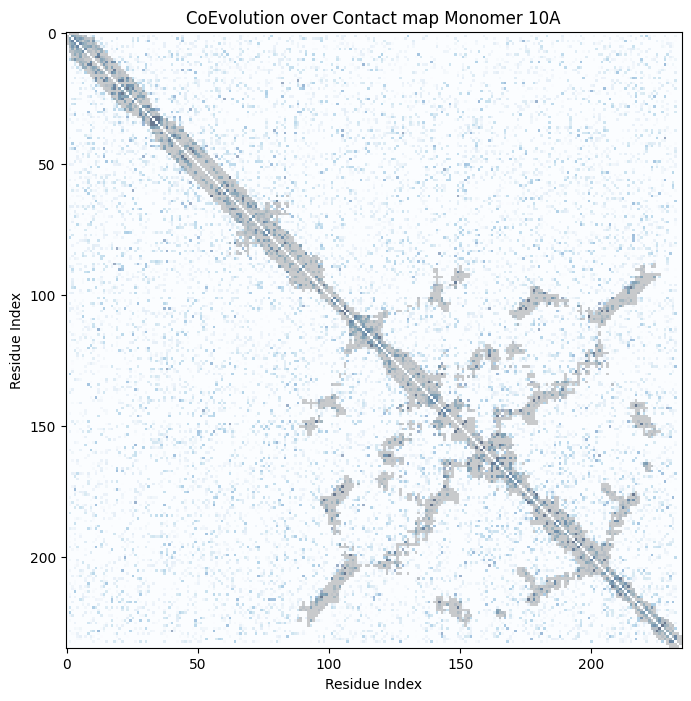

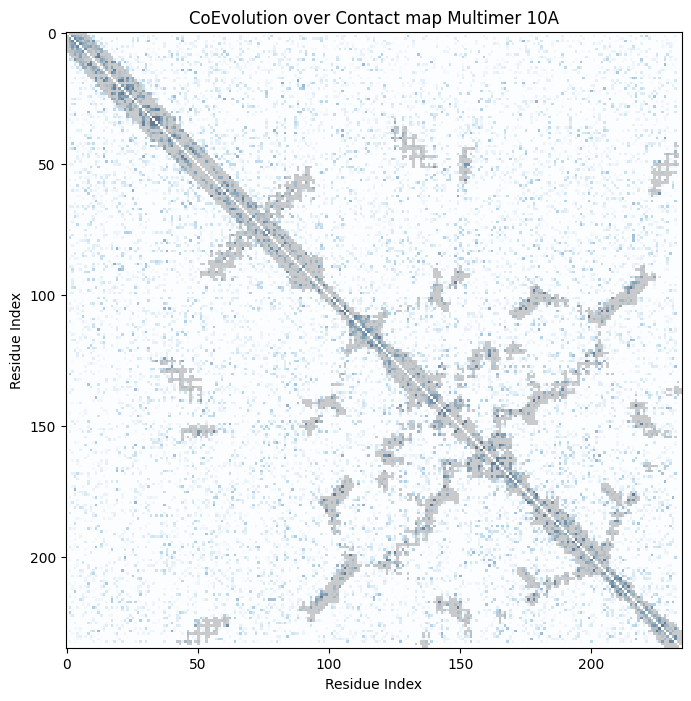

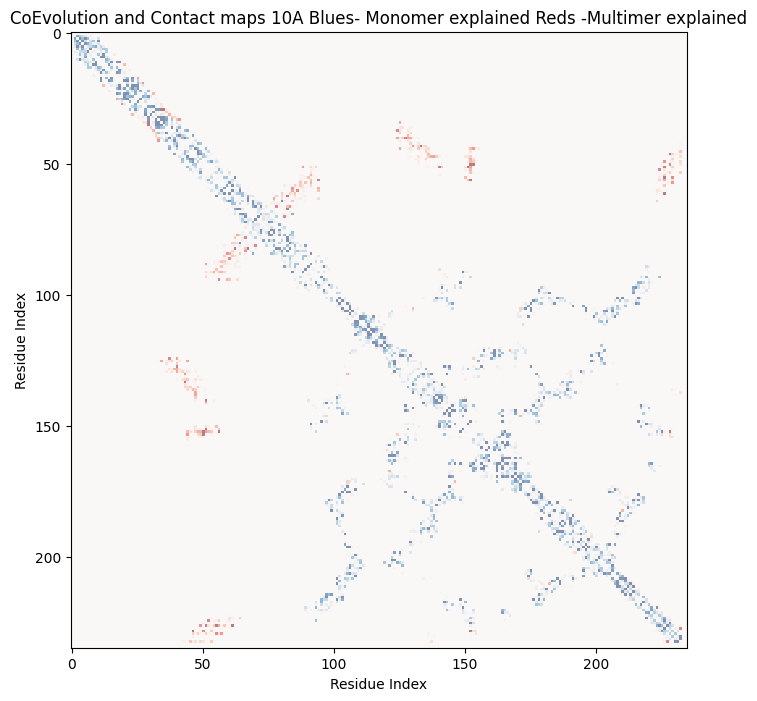

ALL interactions: 4066
MONOMER interactions: 1936
MULTIMER interactions: 272
Coevolution explained by Monomer: 47.61436301032956 %
Coevolution explained by Multimer: 6.689621249385145 %


<Figure size 640x480 with 0 Axes>

In [ ]:
#@title Input model contact maps compared to Coevolution
import numpy as np
from scipy.signal import correlate2d
import matplotlib.pyplot as plt

# Load the data
coev_mtx.to_csv("coevolution.txt", sep='\t', index=False, header=False)
df = pd.read_csv('coevolution.txt', delimiter='\t', header=None, names=['row', 'column', 'value'])

import pandas as pd
import numpy as np

# Load the data back into a DataFrame
df = pd.read_csv('coevolution.txt', delimiter='\t', header=None, names=['row', 'column', 'value'])


# Convert row and column to integers
df['row'] = df['row'].astype(int)
df['column'] = df['column'].astype(int)

# Find the matrix size based on the maximum row and column values
max_row = df['row'].max()
max_column = df['column'].max()
matrix_size = max(max_row, max_column)

# Initialize the matrix with zeros
matrix = np.zeros((matrix_size, matrix_size))

# Populate the matrix with values from the DataFrame
for _, row in df.iterrows():
    r = int(row['row']) - 1  # Explicitly cast to integer
    c = int(row['column']) - 1  # Explicitly cast to integer
    value = row['value']

    # Assign the value to the matrix
    matrix[r, c] = value
    matrix[c, r] = value  # Ensure symmetry by filling both [r, c] and [c, r]

# Set diagonal values to 0
np.fill_diagonal(matrix, 0)

# The final matrix is now stored in the variable 'matrix'
coev_truematrix = matrix

np.savetxt('aggregated_contact_map.txt', aggregated_contact_map, fmt='%d', delimiter='\t')
np.savetxt('coevolution_contact_map.txt', coev_truematrix, fmt='%d', delimiter='\t')

def pad_matrix(matrix, target_shape):
    # Create an empty matrix of the target shape
    padded_matrix = np.zeros(target_shape)

    # Compute the padding sizes (only pad at the end)
    end_y = matrix.shape[0]
    end_x = matrix.shape[1]

    # Place the matrix at the start, pad at the end
    padded_matrix[:end_y, :end_x] = matrix
    return padded_matrix

matrix1 = coev_truematrix
matrix2 = aggregated_contact_map
if multimer == True:
  matrix3 = aggregated_contact_map1

# Find the best alignment
# Define the target shape (use the shape of the larger matrix)
target_shape = (max(matrix1.shape, matrix2.shape))

# Pad matrices
padded_matrix1 = pad_matrix(matrix1, target_shape)
padded_matrix2 = pad_matrix(matrix2, target_shape)
if multimer == True:
  padded_matrix3 = pad_matrix(matrix3, target_shape)

normalized_matrix1 = padded_matrix1
normalized_matrix2 = padded_matrix2
if multimer == True:
  normalized_matrix3 = padded_matrix3
plt.figure(figsize=(8, 8))
plt.imshow(normalized_matrix1, cmap='Blues', alpha=0.5, interpolation='none', vmin =0.5 , vmax =3)
# Plot second matrix
plt.imshow(normalized_matrix2, cmap='Greys', alpha=0.2, interpolation='none')
plt.title('CoEvolution over Contact map Monomer 10A')
plt.xlabel('Residue Index')
plt.ylabel('Residue Index')
plt.show()
plt.figure(figsize=(8, 8))
plt.imshow(normalized_matrix1, cmap='Blues', alpha=0.5, interpolation='none', vmin =0.5 , vmax =3)
# Plot second matrix
if multimer == True:
  plt.imshow(normalized_matrix3, cmap='Greys', alpha=0.2, interpolation='none')
  plt.title('CoEvolution over Contact map Multimer 10A')
  plt.xlabel('Residue Index')
  plt.ylabel('Residue Index')
  plt.show()
import numpy as np
from scipy.stats import pearsonr

# Ensure matrices are of the same size
if normalized_matrix1.shape != normalized_matrix2.shape:
    raise ValueError("Matrices must have the same dimensions to compute correlation.")
if multimer == True:
  if normalized_matrix1.shape != normalized_matrix3.shape:
      raise ValueError("Matrices must have the same dimensions to compute correlation.")
super0 = (normalized_matrix1)*(normalized_matrix1)
super = (normalized_matrix1)*(normalized_matrix1) * normalized_matrix2 #here is the point its changed to be a new matrix from contact map - we can remove that
super3 = normalized_matrix1
super3[normalized_matrix2 == 1] = 0
if multimer == True:
  super2 = (normalized_matrix1)*(normalized_matrix1) * normalized_matrix3
plt.figure(figsize=(8, 8))
if multimer == False:
  plt.imshow(super3, cmap='Reds', alpha=1, interpolation='none', vmin =1, vmax =3)
  plt.title('CoEvolution not explained by Monomer')
# Plot second matrix
if multimer == True:
  plt.imshow(super, cmap='Blues', alpha=1, interpolation='none', vmin =0.5, vmax =5)
  plt.imshow(super2, cmap='Reds', alpha=0.5, interpolation='none', vmin =0, vmax =5)
  plt.title('CoEvolution and Contact maps 10A Blues- Monomer explained Reds -Multimer explained')
plt.xlabel('Residue Index')
plt.ylabel('Residue Index')
plt.show()
plt.savefig(f'CoEvolution Compared.jpg', dpi=300)
np.savetxt('super_contact_map.txt', super, delimiter='\t')
if multimer == True:
  np.savetxt('super1_contact_map.txt', super2, delimiter='\t')
import numpy as np
import pandas as pd

matrix1 = super
if multimer == True:
  matrix2 = super2

# Threshold value
threshold = 0

# Function to create a list of residues from a matrix
def find_residues_above_threshold(matrix, threshold):
    residues = []
    n = matrix.shape[0]
    for i in range(n):
        for j in range(n):
            if matrix[i, j] > threshold:
                residues.append((i+1, j+1 , matrix[i, j]))  # (i+1, j+1) to match 1-based index
    return residues

# Get residues above the threshold in both matrices
residues_matrix1 = find_residues_above_threshold(matrix1, threshold)
residues_matrix0 = find_residues_above_threshold(super0, threshold)
if multimer == True:
  matrix2 = super2
  residues_matrix2 = find_residues_above_threshold(matrix2, threshold)

# Convert to DataFrames for easier comparison
df_matrix1 = pd.DataFrame(residues_matrix1, columns=['i', 'j', 'value'])
df_matrix0 = pd.DataFrame(residues_matrix0, columns=['i', 'j', 'value'])
if multimer == True:
  df_matrix2 = pd.DataFrame(residues_matrix2, columns=['i', 'j', 'value'])
if multimer == True:
# Merge DataFrames to find rows that are in df_matrix2 but not in df_matrix1
  df_diff = pd.merge(df_matrix2, df_matrix1, on=['i', 'j'], how='left', suffixes=('', '_matrix1'))
  df_diff = df_diff[df_diff['value_matrix1'].isna()].drop(columns=['value_matrix1'])

# Rename columns for clarity
  df_diff.columns = ['i', 'j', 'value_in_matrix2']
  df_diff = pd.merge(df_diff, coev_mtx, on=['i', 'j'], how='left')

# Replace 'value_in_matrix2' with 'zscore' from coev_mtx
  df_diff['value_in_matrix2'] = df_diff['zscore']

# Drop the zscore column if you only want value_in_matrix2
  df_diff = df_diff.drop(columns=['zscore'])
  df_diff.columns = ["A", "B", "Score"]
  df_diff = df_diff[df_diff['Score'] >= 1]
  df_diff = df_diff.dropna(subset=['Score'])
  df = df_diff.copy()
  df = df.add([1,1,0])
  df = df.sort_values('Score',ascending=False)
  df = df.reset_index()
  del df['index']
  df.to_csv('sorted_file.csv', sep=' ', index=False)
  calc_coev = coev_mtx.copy()
  calc_coev.columns = ["A", "B", "Score"]
  calc_coev = calc_coev[calc_coev['Score'] > 1]
  calc_coev = calc_coev.dropna(subset=['Score'])
  df_matrix1.columns = ["A", "B", "Score"]
  df_matrix1 = df_matrix1[df_matrix1['Score'] >= 1]
  df_matrix1 = df_matrix1.dropna(subset=['Score'])
  df_matrix2.columns = ["A", "B", "Score"]
  df_matrix2 = df_matrix2[df_matrix2['Score'] >= 1]
  df_matrix2 = df_matrix2.dropna(subset=['Score'])
  num_rows = len(calc_coev )
  num_rows1 = len(df_matrix1)
  num_rows2 = len(df_matrix2)
  num_rows3 = len(df)
  print("ALL interactions:", num_rows)
  print("MONOMER interactions:", num_rows1)
  print("MULTIMER interactions:", num_rows2)
  print("Coevolution explained by Monomer:", (num_rows1/num_rows)*100,'%')
  print("Coevolution explained by Multimer:", (num_rows2/num_rows)*100,'%')
  with open('output.txt', 'w') as file:
      file.write(f"Inter-molecular interactions explained only by Multimer\n")
      file.write(f"{df}\n")
      file.write(f"ALL interactions: {num_rows}\n")
      file.write(f"MONOMER interactions: {num_rows1}\n")
      file.write(f"MULTIMER interactions: {num_rows2}\n")
      file.write(f"Coevolution explained by Monomer: {(num_rows1/num_rows)*100}%\n")
      file.write(f"Coevolution explained by Multimer: {(num_rows2/num_rows)*100}%\n")
else:
    df_diff = pd.merge(df_matrix0, df_matrix1, on=['i', 'j'], how='left', suffixes=('', '_matrix0'))
    df_diff = df_diff[df_diff['value_matrix0'].isna()].drop(columns=['value_matrix0'])
    df_diff.columns = ['i', 'j', 'value_in_matrix0']
    df_diff = pd.merge(df_diff, coev_mtx, on=['i', 'j'], how='left')
    df_diff['value_in_matrix0'] = df_diff['zscore']
    df_diff = df_diff.drop(columns=['zscore'])
    df_diff.columns = ["A", "B", "Score"]
    df_diff = df_diff[df_diff['Score'] >= 1]
    df_diff = df_diff.dropna(subset=['Score'])
    df = df_diff.copy()
    df = df.add([1,1,0])
    df = df.sort_values('Score',ascending=False)
    df = df.reset_index()
    del df['index']
    df.to_csv('UnexplainedCoevolution.csv', sep=' ', index=False)



In [ ]:
print('Inter-molecular interactions explained only by Multimer')
print(df)

Inter-molecular interactions explained only by Multimer
      A    B     Score
0    31   36  2.759058
1    58  154  2.752741
2    31   37  2.713378
3    69   84  2.616276
4    63  228  2.405711
..  ...  ...       ...
65  156  230  1.030538
66  139  234  1.022089
67   62  225  1.021106
68   47  154  1.007347
69  156  231  1.004655

[70 rows x 3 columns]


In [ ]:
#@title Visualise Co-evolution interactions only in Multimer { display-mode: "form" }
# @markdown This will show interactions that occur in coevolution that are only explainable in the multimer. You may set thresholds. **There will be an error if you didnt have an input multimer, as there is no model on which to annotate.**
import pandas as pd
from google.colab import files
!curl -L -O "https://github.com/conda-forge/miniforge/releases/latest/download/Miniforge3-$(uname)-$(uname -m).sh"
!bash Miniforge3-Linux-x86_64.sh -b -p /content/mambaforge -u

# Force PATH update in the shell
!export PATH=/content/mambaforge/bin:$PATH

import os
os.environ['PATH'] = f"/content/mambaforge/bin:{os.environ['PATH']}"
import sys
sys.path.append('/content/mambaforge/lib/python3.10/site-packages') # adjust python version if needed.

# Clear PYTHONPATH
if 'PYTHONPATH' in os.environ:
    del os.environ['PYTHONPATH']
!which mamba
!mamba --version
!mamba install -c conda-forge pymol-open-source -y
!mamba install -c conda-forge tqdm -y
jobname = os.path.splitext(filename)[0]
df = pd.read_csv('sorted_file.csv', delimiter=' ')
GREM_threshold = 1 #@param
print(df.columns)  # Print column names to verify
Angstrom_cutoff = 15 #@param {type:"number"}
# Extract the relevant columns
if ':' in query_sequence:
  residue_pairs_df = df[df['Score'] > GREM_threshold][['A', 'B']]
  residue_pairs_df.to_csv('residues_above_threshold.csv', index=False)

  # Generate PyMOL script

  pym_script = []
  pym_script.append(f"cmd.load('{pdb_filename1}.pdb')")
  pym_script.append('cmd.color("gray90")')
  pym_script.append('cmd.cartoon("automatic")')
  pym_script.append('cmd.set("dash_radius", 0.4)')
  pym_script.append('cmd.set("dash_color", "red")')
  pym_script.append('cmd.bg_color("white")')

  # Load the residue pairs from residues_above_threshold.csv
  selected_residue_pairs = pd.read_csv('residues_above_threshold.csv')

  for index, row in selected_residue_pairs.iterrows():
      res_A = row['A']
      res_B = row['B']

    # Add distance to PyMOL script for each residue pair
      pym_script.append(f'cmd.distance("{res_A}-{res_B}", "resi {res_A} and name CA and chain A", "resi {res_B} and name CA and chain B", cutoff={Angstrom_cutoff} )')

  pym_script.append(f'cmd.save("{jobname}.pse")')

  # Write the PyMOL script to a file
  with open(f"script.py", 'w') as pym_script_file:
      pym_script_file.write('\n'.join(pym_script))

  # Load the PyMOL script
  pym_script_filename = f"script.py"
  !pymol -cq script.py

  # Save the created as a .pse file
  pse_filename = f"{jobname}.pse"

  # Download the .pse file
  files.download(f"{jobname}.pse")
else:
  residue_pairs_df = df[df['Score'] > GREM_threshold][['A', 'B']]
  residue_pairs_df.to_csv('residues_above_threshold.csv', index=False)

  # Generate PyMOL script

  pym_script = []
  pym_script.append(f"cmd.load('{pdb_filename1}')")
  pym_script.append('cmd.color("gray90")')
  pym_script.append('cmd.cartoon("automatic")')
  pym_script.append('cmd.set("dash_radius", 0.4)')
  pym_script.append('cmd.set("dash_color", "red")')
  pym_script.append('cmd.bg_color("white")')

  # Load the residue pairs from residues_above_threshold.csv
  selected_residue_pairs = pd.read_csv('residues_above_threshold.csv')

  chains = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123452789"

  for index, row in selected_residue_pairs.iterrows():
      res_A = row['A']
      res_B = row['B']  # Iterate over all pairs of chains
      for chain1 in chains:
          for chain2 in chains:
            if chain1 != chain2:
              pym_script.append(f'cmd.distance("{res_A}-{res_B}", "resi {res_A} and name CA and chain {chain1}", "resi {res_B} and name CA and chain {chain2}", cutoff={Angstrom_cutoff} )')

# Save the PyMOL session
  pym_script.append(f'cmd.save("{jobname}.pse")')

  # Write the PyMOL script to a file
  with open(f"script.py", 'w') as pym_script_file:
      pym_script_file.write('\n'.join(pym_script))

  # Load the PyMOL script
  pym_script_filename = f"script.py"
  !pymol -cq script.py

  # Save the created as a .pse file
  pse_filename = f"{jobname}.pse"
  files.download(f"{jobname}.pse")

⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:20
🔁 Restarting kernel...
Channels:
 - conda-forge
Platform: linux-64
Solving environment: \ | / - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - pymol-open-source


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    alsa-lib-1.2.13            |       hb9d3cd8_0         547 KB  conda-forge
    attr-2.5.1                 |       h166bdaf_1          69 KB  conda-forge
    blosc-1.21.6               |       he440d0b_1          47 KB  conda-forge
    cairo-1.18.2               |       h3394656_1         956 KB  conda-forge
    conda-24.11.3              |  py311h38be061_0         1.1 MB  conda-forge
    cyrus-sasl-2.1.27 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@markdown Please note that no angstrom cutoff is performed, therefore non-sensible residues will be displayed also, unlike the downloaded version. In addition, the interaction partners are not shown.
import pandas as pd
import py3Dmol
from google.colab import files
jobname = os.path.splitext(filename)[0]
!conda install -c conda-forge pymol-open-source -y
!conda install -c conda-forge tqdm -y
df = pd.read_csv('sorted_file.csv', delimiter=' ')
GREM_threshold = 1 #@param
print(df.columns)  # Print column names to verify
# Extract the relevant columns
residue_pairs_df = df[df['Score'] > GREM_threshold][['A', 'B']]
residue_pairs_df.to_csv('residues_above_threshold.csv', index=False)

df = pd.read_csv('residues_above_threshold.csv')

# Initialize dictionaries to keep track of the usage count of each residue in both chains
chain1_counts = {}
chain2_counts = {}

# Extract values from the desired columns
chain1_column = 'A'  # Specify the column header for chain 1
chain2_column = 'B'  # Specify the column header for chain 2
chain1_values = df[chain1_column].tolist()
chain2_values = df[chain2_column].tolist()

# Load the PDB file
pdb_file = f'{jobname}.pdb'
with open(pdb_file, 'r') as f:
    pdb_data = f.read()

# Create a py3Dmol view
view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')

# Add the PDB data to the view
view.addModel(pdb_data, 'pdb')

# Style the first chain as a cartoon
view.setStyle({'chain': 'A'}, {'cartoon': {'color': 'grey'}})

# Style the second chain as a cartoon
view.setStyle({'chain': 'B'}, {'cartoon': {'color': 'white'}})

green_colors = ['Navy','Blue','LightBlue','Salmon', 'Red', 'DarkRed']
red_colors = ['Navy','Blue','LightBlue','Salmon', 'Red', 'DarkRed']
# Style the residues and add labels
for idx, row in df.iterrows():
    chain1 = 'A'
    res1 = str(row['A'])
    chain2 = 'B'
    res2 = str(row['B'])

    # Update the usage count for each residue
    chain1_counts[res1] = chain1_counts.get(res1, 0) + 1
    chain2_counts[res2] = chain2_counts.get(res2, 0) + 1

    color1 = green_colors[min(chain1_counts[res1], len(green_colors)) - 1]
    color2 = red_colors[min(chain2_counts[res2], len(red_colors)) - 1]

    # Style the residues with spheres and add labels
    view.setStyle({'chain': chain1, 'resi': res1}, {'sphere': {'color': color1, 'radius': 1}})

    view.setStyle({'chain': chain2, 'resi': res2}, {'sphere': {'color': color2, 'radius': 1}})

# Show the view
view.zoomTo()
view.show()

In [ ]:
#@title Download output file
files.download(f"output.txt")
